In [1]:
import pandas as pd
## This is good to do for accounting values
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
gl = pd.read_excel(r'data/general-ledger-sample.xlsx')

In [5]:
gl.head()

Type  Unnamed: 1       Date  \
NaN Company Checking Account NaN NaN NaN      NaN         nan        NaT   
    NaN                      NaN NaN NaN    Check         nan 2018-01-01   
                                     NaN    Check         nan 2018-01-01   
                                     NaN  Deposit         nan 2018-01-01   
                                     NaN    Check         nan 2018-01-05   

                                          Unnamed: 3   Num  Unnamed: 5  Adj  \
NaN Company Checking Account NaN NaN NaN         nan   NaN         nan  nan   
    NaN                      NaN NaN NaN         nan  5001         nan  nan   
                                     NaN         nan  5000         nan  nan   
                                     NaN         nan   NaN         nan  nan   
                                     NaN         nan  5002         nan  nan   

                                          Unnamed: 7                  Name  \
NaN Company Checking Account NaN NaN NaN         nan                   NaN   
    NaN                      NaN NaN NaN         nan        Kuver Property   
                                     NaN         nan     Online Accounting   
                                     NaN         nan                   NaN   
                                     NaN         nan  Deborah Wood (Owner)   

                                          Unnamed: 9                    Memo  \
NaN Company Checking Account NaN NaN NaN         nan                     NaN   
    NaN                      NaN NaN NaN         nan            Janaury Rent   
                                     NaN         nan  Set up QuickBooks file   
                                     NaN         nan                 Deposit   
                                     NaN         nan              Petty Cash   

                                          Unnamed: 11               Split  \
NaN Company Checking Account NaN NaN NaN          nan                 NaN   
    NaN                      NaN NaN NaN          nan                Rent   
                                     NaN          nan     Accounting Fees   
                                     NaN          nan             -SPLIT-   
                                     NaN          nan  Petty Cash Account   

                                          Unnamed: 13     Debit  Unnamed: 15  \
NaN Company Checking Account NaN NaN NaN          nan       nan          nan   
    NaN                      NaN NaN NaN          nan       nan          nan   
                                     NaN          nan       nan          nan   
                                     NaN          nan 31,349.00          nan   
                                     NaN          nan       nan          nan   

                                          Credit  Unnamed: 17   Balance  
NaN Company Checking Account NaN NaN NaN     nan          nan 12,349.00  
    NaN                      NaN NaN NaN  583.75          nan 11,765.25  
                                     NaN  225.00          nan 11,540.25  
                                     NaN     nan          nan 42,889.25  
                                     NaN  500.00          nan 42,389.25

A general ledger (GL) is a set of numbered accounts a business uses to keep track of its financial transactions and to prepare financial reports.

In [6]:
## A parser to fix the above issue. 
def acct_append(row, new_accts):
    if pd.isnull(row[1]):
        new_accts.append(row[0])
    else:
        new_accts.append('{} | {}'.format(*row))


def fix_qb_gl(gl):
    gl = gl.dropna(axis=1, how='all')
    main_acct = list(gl.index.get_level_values(1))
    sub_acct = list(gl.index.get_level_values(2))
    acct = list(zip(main_acct, sub_acct))
    new_accts = []
    acct_append(acct[0], new_accts)
    
    for idx, (m, s) in enumerate(acct[1:]):
        if str(m).startswith('Total'):
            m = 'DELETE'       
        if str(s).startswith('Total'):
            s = 'DELETE'
        idx += 1
        acct[idx] = m, s

        if pd.isnull(m):  # Fill NA if main is NA
            acct[idx] = acct[idx - 1][0], acct[idx][1]
            
            if pd.isnull(s):  # If main is NA, then fill NA if sub is NA
                acct[idx] = acct[idx][0], acct[idx-1][1]

        acct_append(acct[idx], new_accts)  # Create the new acct
    gl = gl.reset_index(drop=True)
    gl['Acct'] = pd.Series(new_accts)
    gl[['Debit', 'Credit']] = gl[['Debit', 'Credit']].fillna(0)
    gl['Net'] = gl.apply(lambda x: (x['Debit'] - x['Credit']
                                    if 'DELETE' not in x['Acct']
                                    else 0), axis=1)
    gl = gl.fillna('NA')
    gl = gl.where(gl['Net'] != 0).dropna()
    columns = ['Acct', 'Type', 'Date', 'Num', 'Name', 'Memo',
               'Split', 'Debit', 'Credit', 'Net']
    gl = gl[columns]
    gl['Date'] = gl['Date'].apply(pd.datetime.date)
    return gl

In [7]:
gl = fix_qb_gl(gl)

For the majority of the transactions, only one side Credit or Debit gets called on. The net effect gets reported on the right. Net is simply the cash inflow and outflow if your accounts are prepared on the cash basis. If your accounts are prepared on the accrual basis. 

Account on the left is the accounts that is credited or debited.

Name is the name of the person or company the transaction is associated with. Memo is a note to help improve the visibility of the transaction. Split is the contra account that is also influenced as part of the double ledger accounting system. The split lines are where the balances get set or recalibrated. 

In [15]:
len(gl.Name.unique())

111

In [20]:
gl[gl.Acct == 'Inventory Asset'].head(5)

,Acct,Type,Date,Num,Name,Memo,Split,Debit,Credit,Net
624,Inventory Asset,Bill,2018-01-02,76850-2,Peacock Bulb Manufacturing Company,"Specialty Bulbs, 100 watt (6 pack)",Accounts Payable,28.50,0.00,28.50
625,Inventory Asset,Bill,2018-01-02,76850-2,Peacock Bulb Manufacturing Company,"Cand. Light, 20 watts (8 pack)",Accounts Payable,48.00,0.00,48.00
626,Inventory Asset,Bill,2018-01-06,87865,Paulsen's Lighting,"Tiffany Collection,Golden Baroque, 1-light lan...",Accounts Payable,"2,400.00",0.00,"2,400.00"
627,Inventory Asset,Invoice,2018-01-06,71047,Baker's Professional Lighting:Store #25,"Pearl Nickle, 5 Light, Medium Base (100 watt max)",Accounts Receivable,0.00,240.00,-240.00
628,Inventory Asset,Invoice,2018-01-06,71047,Baker's Professional Lighting:Store #25,"Black Finish, Solid Brass, Clear Glass, Hangin...",Accounts Receivable,0.00,36.00,-36.00


Now you can run some custom filter commands. For example here you filter the Inventory Asset and also the net amount. Only amounts above 6000 are printed.

In [27]:
gl[gl.Acct == 'Inventory Asset'].where(abs(gl[gl.Acct == 'Inventory Asset'].Net) > 6000).dropna()

,Acct,Type,Date,Num,Name,Memo,Split,Debit,Credit,Net
794,Inventory Asset,Bill,2018-03-09,R909878,Paulsen's Lighting,Golden Umber (100 watt) Six Light Chandelier,Accounts Payable,"8,500.00",0.00,"8,500.00"
795,Inventory Asset,Bill,2018-03-09,R909878,Paulsen's Lighting,Burnished Brass (60 watt) w/Golden Umber Accents,Accounts Payable,"7,500.00",0.00,"7,500.00"
1348,Inventory Asset,Bill,2018-09-06,6785,Hall Lighting & Accessories,"Sunset, Clear Glass, 1-100 watt max.",Accounts Payable,"7,500.00",0.00,"7,500.00"


Here is an example of filtering between certain dates.

In [28]:
start_date = pd.datetime(2018,1,27).date()
end_date = pd.datetime(2018,1,28).date()
gl.where((start_date <= gl.Date) & (gl.Date <= end_date)).dropna()

,Acct,Type,Date,Num,Name,Memo,Split,Debit,Credit,Net
444,Accounts Receivable,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,NA,-SPLIT-,854.00,0.00,854.00
445,Accounts Receivable,Invoice,2018-01-28,71072,Cole Home Builders:Phase 2 - Lot 5,NA,-SPLIT-,"2,187.45",0.00,"2,187.45"
446,Accounts Receivable,Payment,2018-01-28,254,Miscellaneous - Retail:Alison Johnson,71053,Undeposited Funds,0.00,854.00,-854.00
670,Inventory Asset,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,"Tapestry, (2-60 watt Med), Etched Cracked Glas...",Accounts Receivable,0.00,30.00,-30.00
671,Inventory Asset,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,Tapestry (8/60 watt) Faux Alabaster Glass,Accounts Receivable,0.00,75.00,-75.00
672,Inventory Asset,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,"Vianne Lanterns, Satin Antiqued Solid Brass, 3...",Accounts Receivable,0.00,193.79,-193.79
673,Inventory Asset,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,"White, 4.5x7.5, 1-100 watt Medium Base, Satin ...",Accounts Receivable,0.00,30.00,-30.00
674,Inventory Asset,Invoice,2018-01-28,71072,Cole Home Builders:Phase 2 - Lot 5,"Die Cast Lanterns, Black, 1-100 watt, Medium B...",Accounts Receivable,0.00,228.00,-228.00
675,Inventory Asset,Invoice,2018-01-28,71072,Cole Home Builders:Phase 2 - Lot 5,"Tapestry, (2-60 watt Med), Etched Cracked Glas...",Accounts Receivable,0.00,90.00,-90.00
676,Inventory Asset,Invoice,2018-01-28,71072,Cole Home Builders:Phase 2 - Lot 5,"Pearl Nickle, 5 Light, Medium Base (100 watt max)",Accounts Receivable,0.00,160.00,-160.00


This is simply a pivot table that sums up each unique accounts. 

In [10]:
pivot = gl.pivot_table(values=['Debit', 'Credit', 'Net'], index='Acct', aggfunc='sum', margins=True)
accts = list(gl.Acct.unique())
accts.append('All')
pivot.loc[accts]

,Credit,Debit,Net
Acct,,,
Company Checking Account,"403,171.13","480,976.45","77,805.32"
Petty Cash Account,0.00,500.00,500.00
Accounts Receivable,"375,976.45","408,309.53","32,333.08"
Inventory Asset,"173,360.75","131,301.50","-42,059.25"
Prepaids | Prepaid Insurance,"6,875.00","6,875.00",0.00
Undeposited Funds,"375,976.45","375,976.45",0.00
Computer & Office Equipment,0.00,"2,500.00","2,500.00"
Accumulated Depreciation,923.04,0.00,-923.04
Accounts Payable,"147,728.80","131,031.50","-16,697.30"


Now of course there is countless other things you can do, the possibilities are endless, I will do three of them, and then give a few more ideas for those who which to further extend this notebook

In [ ]:
#aggregation by type. This approach below 

In [31]:
gl.groupby("Type").sum()

,Debit,Credit,Net
Type,,,
Bill,"147,802.80","147,802.80",0.00
Bill Pmt -Check,"131,031.50","131,031.50",0.00
Check,"216,937.78","216,937.78",0.00
Credit Card Charge,"3,453.60","3,453.60",0.00
Deposit,"375,976.45","375,976.45",-0.00
General Journal,"9,006.89","9,006.89",0.00
Inventory Adjust,375.00,375.00,0.00
Invoice,"585,165.28","585,165.28",-0.00
Liability Check,"12,727.50","12,727.50",0.00


Below is an interesting insight as it seems that their has been some contra accounts that have been mistakly categorised.

In [32]:
len(gl.Acct.unique())

58

In [33]:
len(gl.Split.unique())

49

In [40]:
ar = gl[gl["Acct"]=="Accounts Receivable"]; ar

,Acct,Type,Date,Num,Name,Memo,Split,Debit,Credit,Net
438,Accounts Receivable,Invoice,2018-01-06,71047,Baker's Professional Lighting:Store #25,NA,-SPLIT-,"2,381.00",0.00,"2,381.00"
439,Accounts Receivable,Invoice,2018-01-14,71050,Godwin Lighting Depot:Store #202,NA,-SPLIT-,"7,786.40",0.00,"7,786.40"
440,Accounts Receivable,Invoice,2018-01-17,71055,Miscellaneous - Retail:Ms. Jann Minor,NA,-SPLIT-,"1,084.00",0.00,"1,084.00"
441,Accounts Receivable,Payment,2018-01-17,555,Miscellaneous - Retail:Ms. Jann Minor,71055,Undeposited Funds,0.00,"1,084.00","-1,084.00"
442,Accounts Receivable,Invoice,2018-01-18,71092,Miscellaneous - Retail:Brian Stern,NA,-SPLIT-,"1,126.00",0.00,"1,126.00"
443,Accounts Receivable,Payment,2018-01-18,11124,Miscellaneous - Retail:Brian Stern,71092,Undeposited Funds,0.00,"1,126.00","-1,126.00"
444,Accounts Receivable,Invoice,2018-01-28,71053,Miscellaneous - Retail:Alison Johnson,NA,-SPLIT-,854.00,0.00,854.00
445,Accounts Receivable,Invoice,2018-01-28,71072,Cole Home Builders:Phase 2 - Lot 5,NA,-SPLIT-,"2,187.45",0.00,"2,187.45"
446,Accounts Receivable,Payment,2018-01-28,254,Miscellaneous - Retail:Alison Johnson,71053,Undeposited Funds,0.00,854.00,-854.00
447,Accounts Receivable,Invoice,2018-01-29,71124,Kern Lighting Warehouse:Store #34,NA,Revenue,"8,400.00",0.00,"8,400.00"


Okay, now this is important, I will further just investigate Accounts Receivable. Here you can see from the below plot the credit side of AR is slightly lower around the zero bound. This showed that there is slightly less amounts or repayment at that value. 

In [43]:
ar["Debit"].sum()

408309.53

In [44]:
ar["Credit"].sum()

375976.45

This company has clearly done well, there is a very small amoount of AR outstanding.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115d019b0>,
      dtype=object)

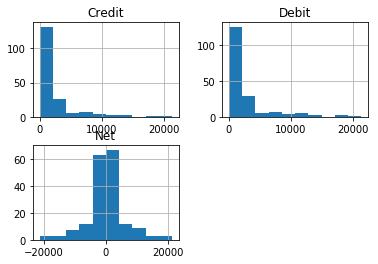

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

ar.hist()

Here you can have a look at the values over the period, the numbers below is the daily values. It seems that towards the end of the period they are extending larger amounts of credit.

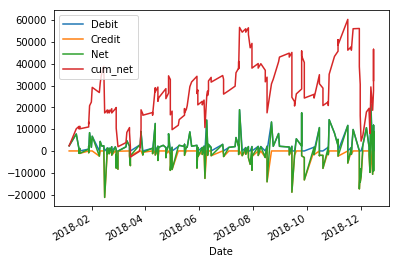

In [66]:
ar.plot()

Now I will create a rolling commulative sum, doing this whe can see if there is any seasonality in the balance.

In [49]:
ar["cum_net"] = ar["Net"].cumsum()

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


You can see that the summation remains within range, it is not to bad, there is a slight increase over the period. To prove there is an increase over time, we can run a linear regression to get the slope coefficient. 

In [55]:
ar["Date"] =  pd.to_datetime(ar["Date"])

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
ar = ar.set_index("Date",drop=True)

In [60]:
ar["Credit"] = - ar["Credit"]

LinregressResult(slope=0.002061083196531608, intercept=32.73900646747864, rvalue=0.5445332646944847, pvalue=1.9277033049221335e-15, stderr=0.00023662564997062874)

In [65]:
ar

,Acct,Type,Num,Name,Memo,Split,Debit,Credit,Net,cum_net
Date,,,,,,,,,,
2018-01-06,Accounts Receivable,Invoice,71047,Baker's Professional Lighting:Store #25,NA,-SPLIT-,"2,381.00",-0.00,"2,381.00","2,381.00"
2018-01-14,Accounts Receivable,Invoice,71050,Godwin Lighting Depot:Store #202,NA,-SPLIT-,"7,786.40",-0.00,"7,786.40","10,167.40"
2018-01-17,Accounts Receivable,Invoice,71055,Miscellaneous - Retail:Ms. Jann Minor,NA,-SPLIT-,"1,084.00",-0.00,"1,084.00","11,251.40"
2018-01-17,Accounts Receivable,Payment,555,Miscellaneous - Retail:Ms. Jann Minor,71055,Undeposited Funds,0.00,"-1,084.00","-1,084.00","10,167.40"
2018-01-18,Accounts Receivable,Invoice,71092,Miscellaneous - Retail:Brian Stern,NA,-SPLIT-,"1,126.00",-0.00,"1,126.00","11,293.40"
2018-01-18,Accounts Receivable,Payment,11124,Miscellaneous - Retail:Brian Stern,71092,Undeposited Funds,0.00,"-1,126.00","-1,126.00","10,167.40"
2018-01-28,Accounts Receivable,Invoice,71053,Miscellaneous - Retail:Alison Johnson,NA,-SPLIT-,854.00,-0.00,854.00,"11,021.40"
2018-01-28,Accounts Receivable,Invoice,71072,Cole Home Builders:Phase 2 - Lot 5,NA,-SPLIT-,"2,187.45",-0.00,"2,187.45","13,208.85"
2018-01-28,Accounts Receivable,Payment,254,Miscellaneous - Retail:Alison Johnson,71053,Undeposited Funds,0.00,-854.00,-854.00,"12,354.85"


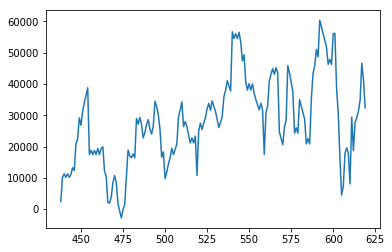

In [51]:
ar["cum_net"].plot()

In [50]:
ar.head()

,Acct,Type,Date,Num,Name,Memo,Split,Debit,Credit,Net,cum_net
438,Accounts Receivable,Invoice,2018-01-06,71047,Baker's Professional Lighting:Store #25,NA,-SPLIT-,"2,381.00",0.00,"2,381.00","2,381.00"
439,Accounts Receivable,Invoice,2018-01-14,71050,Godwin Lighting Depot:Store #202,NA,-SPLIT-,"7,786.40",0.00,"7,786.40","10,167.40"
440,Accounts Receivable,Invoice,2018-01-17,71055,Miscellaneous - Retail:Ms. Jann Minor,NA,-SPLIT-,"1,084.00",0.00,"1,084.00","11,251.40"
441,Accounts Receivable,Payment,2018-01-17,555,Miscellaneous - Retail:Ms. Jann Minor,71055,Undeposited Funds,0.00,"1,084.00","-1,084.00","10,167.40"
442,Accounts Receivable,Invoice,2018-01-18,71092,Miscellaneous - Retail:Brian Stern,NA,-SPLIT-,"1,126.00",0.00,"1,126.00","11,293.40"


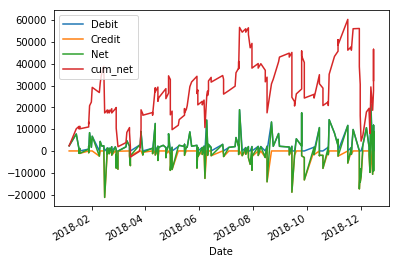

In [67]:
ar.plot()

In [70]:
from scipy.stats import linregress
linregress(list(ar["cum_net"].values), list(range(len(ar))))


LinregressResult(slope=0.002061083196531608, intercept=32.73900646747864, rvalue=0.5445332646944847, pvalue=1.9277033049221335e-15, stderr=0.00023662564997062874)

In [71]:
ar.head()

,Acct,Type,Num,Name,Memo,Split,Debit,Credit,Net,cum_net
Date,,,,,,,,,,
2018-01-06,Accounts Receivable,Invoice,71047,Baker's Professional Lighting:Store #25,NA,-SPLIT-,"2,381.00",-0.00,"2,381.00","2,381.00"
2018-01-14,Accounts Receivable,Invoice,71050,Godwin Lighting Depot:Store #202,NA,-SPLIT-,"7,786.40",-0.00,"7,786.40","10,167.40"
2018-01-17,Accounts Receivable,Invoice,71055,Miscellaneous - Retail:Ms. Jann Minor,NA,-SPLIT-,"1,084.00",-0.00,"1,084.00","11,251.40"
2018-01-17,Accounts Receivable,Payment,555,Miscellaneous - Retail:Ms. Jann Minor,71055,Undeposited Funds,0.00,"-1,084.00","-1,084.00","10,167.40"
2018-01-18,Accounts Receivable,Invoice,71092,Miscellaneous - Retail:Brian Stern,NA,-SPLIT-,"1,126.00",-0.00,"1,126.00","11,293.40"


In [78]:
from wordcloud import WordCloud

wordcloud2 = WordCloud().generate(' '.join(ar['Name']))

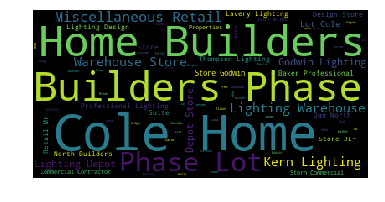

In [79]:
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [80]:
### Here you can focus more on the debtors and look at the debtors aged report.
## https://www.accountingweb.co.uk/tech/tech-pulse/coding-for-accountants-creating-an-aged-debtors-report